In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import glob

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

## Visualize the Image

In [19]:
TRAIN_FILE_PATH = '/kaggle/input/kermany2018/OCT2017 /train/'
TEST_FILE_PATH = '/kaggle/input/kermany2018/OCT2017 /test/'
VAL_FILE_PATH = '/kaggle/input/kermany2018/OCT2017 /val/'

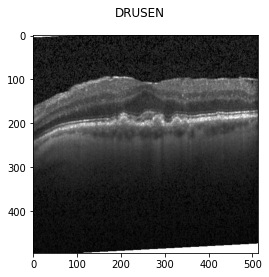

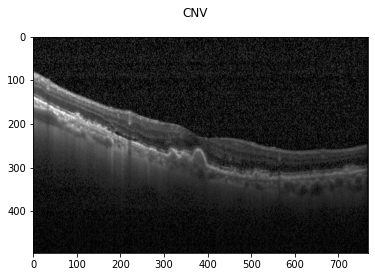

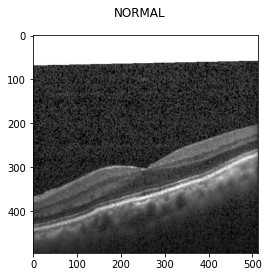

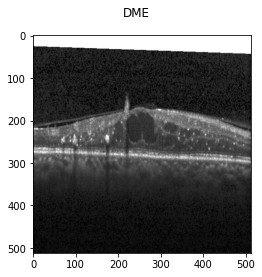

In [3]:
for cat in os.listdir(TRAIN_FILE_PATH):
    path = os.path.join(TRAIN_FILE_PATH, cat)
    for img_path in os.listdir(path):
        image = cv2.imread(os.path.join(path, img_path), 1)
        plt.imshow(image)
        plt.suptitle(f'{cat}')
        plt.show()
        break

## Model Preprocessing

In [4]:
#Hyper tuning parameters
EPOCHS = 10
LR = 64
BS = 128
IMG_SHAPE = (224, 224)
INPUT_SHAPE = [224, 224, 3]

In [5]:
#Data Augumentation using ImageDataGenerator.
train_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.25, shear_range=0.2, 
                               horizontal_flip=True, 
                               vertical_flip=True)

test_gen = ImageDataGenerator(rescale=1./255)

val_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen = train_gen.flow_from_directory(TRAIN_FILE_PATH, target_size=IMG_SHAPE, 
                                               class_mode='categorical', batch_size=BS, shuffle=True)

test_data_gen = test_gen.flow_from_directory(TEST_FILE_PATH, target_size=IMG_SHAPE, 
                                               class_mode='categorical', batch_size=BS, shuffle=True)

val_data_gen = val_gen.flow_from_directory(VAL_FILE_PATH, target_size=IMG_SHAPE, 
                                               class_mode='categorical', batch_size=BS, shuffle=True)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [7]:
train_data_gen.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

## Model Building

In [8]:
def model_building(model_name, INPUT_SHAPE=INPUT_SHAPE):
    print('Model Initialization started')
    base_model = model_name(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    
    for layers in base_model.layers:
        layers.trainable = False
    print('Model Initialization finished')
    
    #model creation
    print('Model creation started')
    inp_model = base_model.output
    
    x = GlobalAveragePooling2D()(inp_model)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(4, activation = 'sigmoid')(x)
    
    model = Model(inputs = base_model.input, outputs = x)
    
    #model summary
    print('Model summary')
    #model.summary()
    
    #model compilation
    model.compile(optimizer = 'adam', metrics=['accuracy'], loss = 'categorical_crossentropy')
    
    history = model.fit(train_data_gen, validation_data=val_data_gen, 
                       validation_steps=len(val_data_gen)//BS,
                       steps_per_epoch=len(train_data_gen)//BS,
                       batch_size=BS, 
                       epochs=EPOCHS)
    
    print('Model Building Finished')
    
    !mkdir -p saved_model
    model.save(f'saved_model/{model_name}_1.h5')
    print('Model was saved')
    
    return model, history

In [9]:
def evaluation_plot(model):
    
    
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(10, 8))
    plt.plot(model['loss'], label = 'loss')
    plt.plot(model['accuracy'], label = 'accuracy')
    #plt.plot(model['val_loss'], label = 'val_loss')
    #plt.plot(model['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.title('Model Evaluation')
    plt.show()

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inc_model, inc_model_hist = model_building(InceptionV3)

Model Initialization started


2022-12-06 12:17:12.669340: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 4s 0us/step
Model Initialization finished
Model creation started
Model summary


2022-12-06 12:17:23.212927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
5/5 [==============================] - 47s 8s/step - loss: 1.9339 - accuracy: 0.4266
Epoch 2/10
5/5 [==============================] - 40s 8s/step - loss: 1.3040 - accuracy: 0.5734
Epoch 3/10
5/5 [==============================] - 40s 8s/step - loss: 0.9718 - accuracy: 0.6141
Epoch 4/10
5/5 [==============================] - 41s 8s/step - loss: 0.9436 - accuracy: 0.6594
Epoch 5/10
5/5 [==============================] - 40s 7s/step - loss: 0.8504 - accuracy: 0.6875
Epoch 6/10
5/5 [==============================] - 40s 8s/step - loss: 0.8446 - accuracy: 0.6984
Epoch 7/10
5/5 [==============================] - 40s 8s/step - loss: 0.7922 - accuracy: 0.7125
Epoch 8/10
5/5 [==============================] - 41s 8s/step - loss: 0.7734 - accuracy: 0.7188
Epoch 9/10
5/5 [==============================] - 40s 8s/step - loss: 0.7020 - accuracy: 0.7484
Epoch 10/10
5/5 [==============================] - 40s 8s/step - loss: 0.7692 - accuracy: 0.7203
Model Building Finished
Model was saved

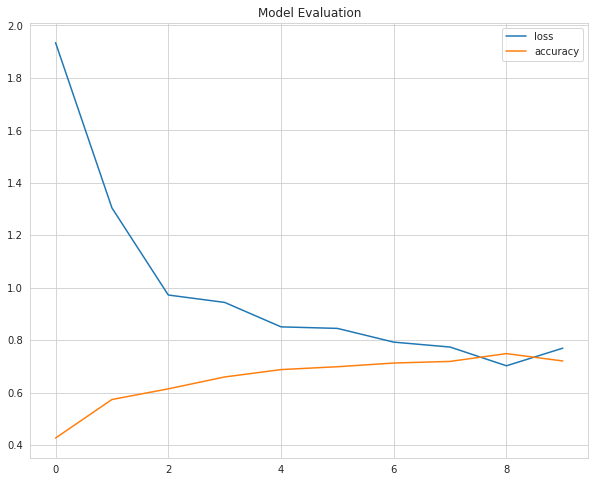

In [11]:
evaluation_plot(inc_model_hist.history)

In [12]:
inc_loss, inc_acc = inc_model.evaluate(test_data_gen)

8/8 [==============================] - 52s 6s/step - loss: 0.9125 - accuracy: 0.5795


#### VGG16 Model

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model, vgg16_model_hist = model_building(VGG16)

Model Initialization started
58900480/58889256 [==============================] - 3s 0us/step
Model Initialization finished
Model creation started
Model summary
Epoch 1/10
5/5 [==============================] - 176s 34s/step - loss: 1.2529 - accuracy: 0.4328
Epoch 2/10
5/5 [==============================] - 174s 34s/step - loss: 1.1855 - accuracy: 0.4625
Epoch 3/10
5/5 [==============================] - 173s 34s/step - loss: 1.1639 - accuracy: 0.6516
Epoch 4/10
5/5 [==============================] - 174s 34s/step - loss: 1.1624 - accuracy: 0.5203
Epoch 5/10
5/5 [==============================] - 174s 34s/step - loss: 1.1196 - accuracy: 0.5375
Epoch 6/10
5/5 [==============================] - 173s 34s/step - loss: 1.0788 - accuracy: 0.6734
Epoch 7/10
5/5 [==============================] - 174s 34s/step - loss: 1.0806 - accuracy: 0.6422
Epoch 8/10
5/5 [==============================] - 175s 35s/step - loss: 1.0723 - accuracy: 0.6094
Epoch 9/10
5/5 [==============================] - 175s 

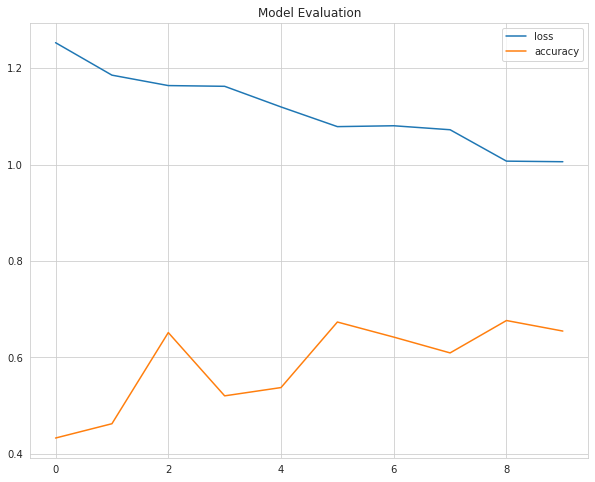

In [14]:
evaluation_plot(vgg16_model_hist.history)

In [20]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(test_data_gen)

8/8 [==============================] - 262s 32s/step - loss: 1.3052 - accuracy: 0.4897


## Model Evaluation

In [26]:
eval_df = pd.DataFrame({'Model Name': ['Inception_V3 Model', 'VGG16 Model'],
                        'Training evaluation Accuracy': [inc_model_hist.history['accuracy'][-1], vgg16_model_hist.history['accuracy'][-1]],
                        'Training evaluation Loss': [inc_model_hist.history['loss'][-1], vgg16_model_hist.history['loss'][-1]], 
                       'Testing evalutaion Accuracy': [inc_acc, vgg16_acc],
                       'Testing evalutaion Loss': [inc_loss, vgg16_loss]})

eval_df.head()

,Model Name,Training evaluation Accuracy,Training evaluation Loss,Testing evalutaion Accuracy,Testing evalutaion Loss
0,Inception_V3 Model,0.720312,0.769217,0.579545,0.912521
1,VGG16 Model,0.654688,1.005954,0.489669,1.305192


In [25]:
inc_model_hist.history['accuracy'][-1]

0.7203124761581421